# Import Tools

In [367]:
import numpy as np
from scipy.integrate import solve_ivp
import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt

### Define RLC ODE in Python

The equation we derived for the standard form of the second-order differential equation for an RLC circuit is as follows:

$$
\frac{d^2i}{dt^2} + 2\alpha \frac{di}{dt} + \omega_0^2 i = 0
$$

In this equation:
- $2\alpha \frac{di}{dt}$ represents the damping due to resistance $R$,
- $\omega_0^2 i$ represents the restoring force due to the inductor and capacitor.

This equation describes how the current $i(t)$ changes over time in response to the parameters of the RLC circuit


The solution of this second-order ODE depends on the nature of the roots of the characteristic equation:

$s^2 + 2\alpha s + \omega_0^2 = 0$

The roots of this equation are:

$s = -\alpha \pm \sqrt{\alpha^2 - \omega_0^2}$

Depending on the values of $\alpha$ and $\omega_0$, there are three cases:

1. **Overdamped** ($\alpha > \omega_0$): The roots are real and distinct, and the solution is:
   $$
   i(t) = A e^{(-\alpha + \sqrt{\alpha^2 - \omega_0^2})t} + B e^{(-\alpha - \sqrt{\alpha^2 - \omega_0^2})t}
   $$

2. **Critically damped** ($\alpha = \omega_0$): The roots are real and repeated, and the solution is:
   $$
   i(t) = (A + Bt) e^{-\alpha t}
   $$

3. **Underdamped** ($\alpha < \omega_0$): The roots are complex, and the solution takes an oscillatory form:
   $$
   i(t) = e^{-\alpha t} (A \cos(\omega_d t) + B \sin(\omega_d t))
   $$
   where $\omega_d = \sqrt{\omega_0^2 - \alpha^2}$ is the damped natural frequency.

In [368]:
# Define the RLC ODE 
def rlc_ode(t, y, alpha, omega_0):
    i, di_dt = y
    d2i_dt2 = -2 * alpha * di_dt - omega_0**2 * i
    return [di_dt, d2i_dt2]

#  Generate Training Data

In [369]:
def generate_data(num_samples):                 # Defines the number of RLC circuit samples to generate
    t_span = (0, 10)                            # Time from 0 to 10 seconds
    t_eval = np.linspace(*t_span, 100)          # 100 equally spaced time points where i(t) will be evaluated
    initial_conditions = [1.0, 0.0]             # Assume the initial current and initial derivative of the circuit

    X_data = []                                 # Store feature vectors, which consist for RLC parameters at the time points
    y_data = []                                 # Store the traget values, which are the values of i(t) at each time point from solve the ODE

    for _ in range(num_samples):                # Loops 'num_samples' times to create a dataset with the specified number of RLC configurations.
        # Randomly generate R, L, C values b/w the values of 0.5 and 2
        R = np.random.uniform(0.5, 2.0)
        L = np.random.uniform(0.5, 2.0)
        C = np.random.uniform(0.5, 2.0)
        
        # Solving for the ODE characteristics
        # Calculate alpha and omega_0
        alpha = R / (2 * L)
        omega_0 = 1 / np.sqrt(L * C)

        # Solve the ODE
        #-----------------------------------------------------------------------------------------------------------
        # HERE IS WHERE WE CAN PLAY AROUND WITH DIFFERENT SOLVING TECHNIQUES
        # This example uses 'solve_ivp' to solve the diffeQ
        #-----------------------------------------------------------------------------------------------------------
        solution = solve_ivp(rlc_ode, t_span, initial_conditions, t_eval=t_eval, args=(alpha, omega_0))
        
        # Store R, L, C, and time points as features, and the solution as labels
        X_data.append(np.hstack(([R, L, C], t_eval)))
        y_data.append(solution.y[0])  # Only the current values

    return np.array(X_data), np.array(y_data)

### Use the fuction `generate_data` that we just defined

In [370]:
X_train, y_train = generate_data(num_samples=10000)

# Define Neural Network

In [371]:
# Step 2: Define the Neural Network Model
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(100, activation='linear')  # Output length matches the number of time points
])

model.summary()

/home/rbrin/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_141 (Dense)               │ (None, 64)             │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 100)            │         6,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,316 (67.64 KB)

 Trainable params: 17,316 (67.64 KB)

 Non-trainable params: 0 (0.00 B)

# Train the Neural Network
Here we can also modify the hyperparameters as needed

In [372]:
model.compile(optimizer='adam', loss='mse', metrics = ['accuracy'])

# Train the Model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2179 - loss: 0.7183 - val_accuracy: 0.3750 - val_loss: 0.0173
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3402 - loss: 0.0160 - val_accuracy: 0.4650 - val_loss: 0.0106
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3684 - loss: 0.0083 - val_accuracy: 0.7075 - val_loss: 0.0066
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4447 - loss: 0.0069 - val_accuracy: 0.1825 - val_loss: 0.0060
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4155 - loss: 0.0062 - val_accuracy: 0.5060 - val_loss: 0.0053
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4285 - loss: 0.0058 - val_accuracy: 0.7170 - val_loss: 0.0048
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4549 - loss: 0.0051 - val_accuracy: 0.9140 - val_loss: 0.0039
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5402 - loss: 0.0043 - val_accu

# Plot the Results

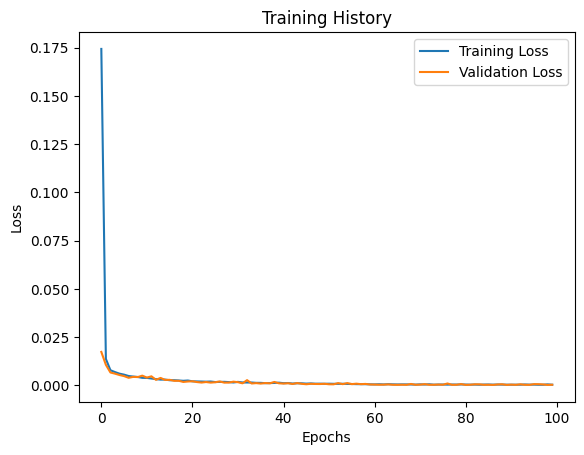

In [373]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training History')
plt.show()


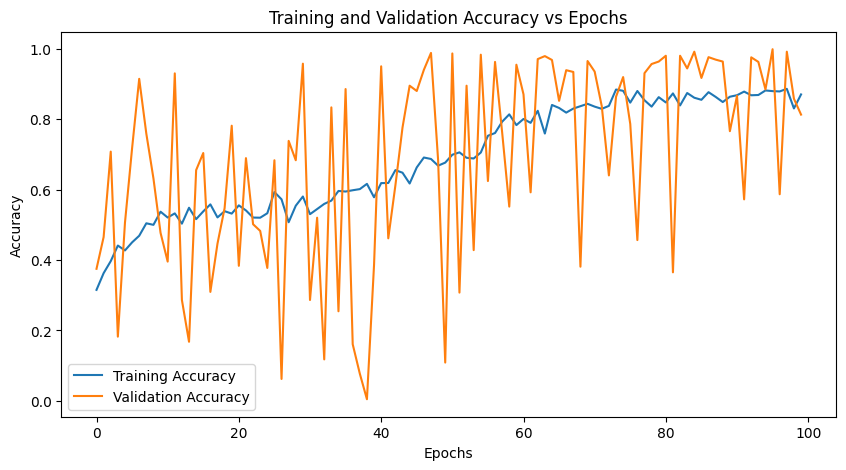

In [374]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy vs Epochs')
plt.show()

# Test the Trained Model on Test Circuit

In [375]:
# Step 4: Test the Model on New Data
R_test, L_test, C_test = 1.0, 1.0, 1.0  # Test RLC values
I0, dI0_dt = 1.0, 0.0
alpha_test = R_test / (2 * L_test)
omega_0_test = 1 / np.sqrt(L_test * C_test)


# Generate test time points
t_test = np.linspace(0, 10, 100)
X_test = np.hstack(([R_test, L_test, C_test], t_test))

# Predict the current using the trained model
y_pred = model.predict(X_test.reshape(1, -1)).flatten()

# Solve the ODE directly to compare
solution_test = solve_ivp(rlc_ode, (0, 10), [1.0, 0.0], t_eval=t_test, args=(alpha_test, omega_0_test))
y_true = solution_test.y[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


# Plot the NN against actual Solution

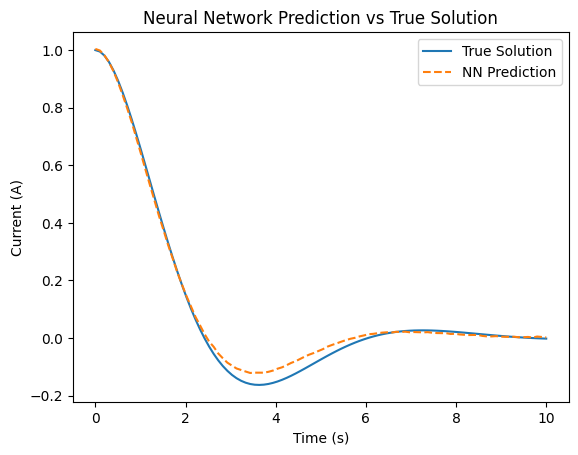

In [376]:
# Plot the neural network prediction vs actual solution
plt.plot(t_test, y_true, label='True Solution')
plt.plot(t_test, y_pred, '--', label='NN Prediction')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.legend()
plt.title('Neural Network Prediction vs True Solution')
plt.show()

### Explanation of the Code

1. **Data Generation**:
   - `generate_data` creates synthetic training samples. We randomly vary $R$, $L$, and $C$ and use `solve_ivp` to compute the current over time.
   - Each feature vector includes the parameters $R$, $L$, $C$, and the time points. Each label is the corresponding current values over time.

2. **Model Definition**:
   - A simple feedforward neural network (Multi-Layer Perceptron) is used. The input layer takes in the RLC parameters and time points, while the output layer provides the current at each time point.

3. **Training**:
   - We train the model using mean squared error (MSE) as the loss function. The `history` variable captures training progress, which we plot to ensure the model is learning.

4. **Testing**:
   - We evaluate the neural network on a new RLC configuration by comparing its prediction with the analytical solution (computed by `solve_ivp`).

### Notes
- The model might benefit from hyperparameter tuning or more sophisticated architectures, such as recurrent neural networks (RNNs) if sequential dependencies are crucial.
- In practice, this model learns to approximate the general response of an RLC circuit across different parameter values without directly solving the ODE at each time step.


# Physics Informed Neural Networks
Physics-Informed Neural Networks (PINNs) are a sophisticated blend of machine learning and classical physics. They incorporate known physical laws, typically represented by differential equations, directly into the neural network's learning process. This integration helps ensure that the model's predictions are not only driven by data but are also consistent with established physical principles.

### Why Use PINNs?

1. **Improved Accuracy**: By embedding physical laws into the network, PINNs can improve the accuracy of predictions, especially in scenarios where data is sparse or noisy.

2. **Generalization**: PINNs often generalize better than purely data-driven models because they leverage fundamental physical laws that are universally applicable.

3. **Solving Complex Problems**: PINNs are particularly useful for solving forward and inverse problems involving complex physical systems, such as fluid dynamics, material science, and quantum mechanics.

### How Do PINNs Work?

1. **Formulating the Problem:** The first step is to define the physical system and the differential equations that describe it. In this case since we are looking at RLC Circuits, we use: $$ \frac{d^2i}{dt^2} + 2\alpha \frac{di}{dt} + \omega_0^2 i = 0 $$

2. **Neural Network Architecture**: A neural network is designed to approximate the solution of the differential equations. It takes as its input time, and produces an output I for current.

3. **Loss Function**: The loss function in a PINN is augmented to include terms that penalize deviations from the physical laws. This typically involves computing residuals of the differential equations using automatic differentiation. 

4. **Training**: The loss function is able to be minimized by know what the output of the equation should be. Because our differential equation is set to $0$, if the output of the neural network does not mach this, a loss is generated. 

In [640]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

### Underdampend Solution
As previously stated, the equation for an underdampend circuit is $ i(t) = e^{-\alpha t} (A \cos(\omega_d t) + B \sin(\omega_d t)) $, where **A** and **B** are our boundary conditions that must be calculated given initial conditions $ i(0) $ and $ di(0)/dt $. With this equation we are able to get the exact current for all points in time.

In [641]:
def rlc_under(t):
    alpha = R_test / (2 * L_test)
    omega_0 = 1 / np.sqrt(L_test * C_test)
    zeta = alpha / omega_0
    omega_d = omega_0 * np.sqrt(1 - zeta ** 2)
    A = I0
    B = dI0_dt + (A * alpha) / omega_d
    
    I = (A  * np.cos(omega_d * t) + B * np.sin(omega_d * t)) * np.exp(-alpha * t)
    
    return I

### Voltage
We can use this function to drive a voltage onto the circuit. Currently, it's set to 0, but could be set to a DC bias or an AC signal.

In [642]:
# Define the input voltage as a function of time
def voltage(t):
    return 0

### Neural Network
We use Tensorflow's Keras to create out network for training. It includes two hidden layers with a tanh activation and a linear output. This output is what we will use as our prediction for current.

In [643]:
# Define the neural network model for current I(t)
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(32, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(32, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(1, activation='linear')

    def call(self, t):
        x = self.dense1(t)
        x = self.dense2(x)
        return self.dense3(x)

### PINN Loss
#### Gradient Tape
Gradient tapes are what Tensorflow uses to implement automatic differentiation. To differentiate automatically, TensorFlow needs to remember what operations happen in what order during the forward pass. Then, during the backward pass, TensorFlow traverses this list of operations in reverse order to compute gradients. 

These gradients are what allows us to create derivatives for the system at each time point. As you can see in the function, $I$ is first calculated by passing $t$ through the model. A gradient is then calculated with these two pieces of information, and this is what creates our first order derivative $dI/dt$. The derivative can then be passed to another gradient to create the second order derivative $d^2I/dt^2$. 

#### Loss Function
After the $I$, $dI/dt$, and $d^2I/dt^2$ are all calculated for a given point of time, they can be entered into our differential equation and an output is calculated. We use this output to calculate our Loss as captured by ode_loss. In this case we use the Mean Squared Error method to determine what the loss is over all points in time. Because this is also an initial value problem we also need to capture the loss of the output at $t(0)$. This is captured by ic_loss which grabs the first term of the $I$ tensor, and compares it to our given initial value for $I$.

In [644]:
# Define the custom loss function for the PINN
def pinn_loss(model, t, V):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        I = model(t)
        dI_dt = tape.gradient(I, t)
        d2I_dt2 = tape.gradient(dI_dt, t)

    ode_loss = L_test * d2I_dt2 + R_test * dI_dt + (1 / C_test) * I + V(t)
    ic_loss = I[0] - I0
    return tf.reduce_mean(tf.square(ode_loss)) + tf.reduce_mean(tf.square(ic_loss))



### Training
We apply the Gradient Tape to the loss 

In [645]:
# Define the training step
@tf.function
def train_step(model, t, V, optimizer):
    with tf.GradientTape() as tape:
        loss = pinn_loss(model, t, V)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss 


In [646]:
def pinn_accuracy(y_true, y_pred):
    y_pred = y_pred.numpy()
    return r2_score(y_true, y_pred)

In [647]:
# Generate training data
t_values = np.linspace(0, 10, 1000).astype(np.float32).reshape(-1, 1)
t_train, _ = train_test_split(t_values, test_size=0.2, random_state=42)


In [648]:
# Instantiate the model and optimizer
pinn_model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)

I_exact = rlc_under(np.linspace(0, 10, 1000))

# Solve the ODE directly to compare
solution_test = solve_ivp(rlc_ode, (0, 10), [1.0, 0.0], t_eval=np.linspace(0,10,1000), args=(alpha_test, omega_0_test), method='RK45')
I_rk45 = solution_test.y[0]

# Train the model
loss_data = []
accuracy_data = []
epochs = 2000
for epoch in range(epochs):
    loss = train_step(pinn_model, t_train, voltage, optimizer)
    I_pred = pinn_model(t_values)
    accuracy_data.append(pinn_accuracy(I_exact, I_pred))
    loss_data.append(loss.numpy())
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')



Epoch 0, Loss: 1.3010541200637817
Epoch 100, Loss: 0.0017588110640645027
Epoch 200, Loss: 0.00060656777350232
Epoch 300, Loss: 0.0002773668384179473
Epoch 400, Loss: 0.0001161595355370082
Epoch 500, Loss: 5.477969170897268e-05
Epoch 600, Loss: 3.521124381222762e-05
Epoch 700, Loss: 2.7852895073010586e-05
Epoch 800, Loss: 2.4459350242977962e-05
Epoch 900, Loss: 2.275001497764606e-05
Epoch 1000, Loss: 2.1763513359474018e-05
Epoch 1100, Loss: 2.1089083020342514e-05
Epoch 1200, Loss: 2.05356100195786e-05
Epoch 1300, Loss: 2.0059025700902566e-05
Epoch 1400, Loss: 1.9620620150817558e-05
Epoch 1500, Loss: 1.921259354276117e-05
Epoch 1600, Loss: 1.875515044957865e-05
Epoch 1700, Loss: 1.8305574485566467e-05
Epoch 1800, Loss: 1.7883476175484248e-05
Epoch 1900, Loss: 1.7446125639253296e-05


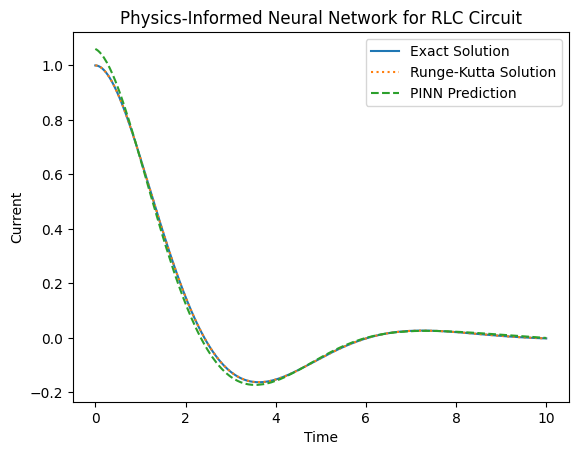

In [649]:
# Predict the current I(t) using the trained model
I_pred = pinn_model(t_values)

# Plot the results
import matplotlib.pyplot as plt


plt.plot(t_values, I_exact, label='Exact Solution')
plt.plot(t_values, I_rk45, label='Runge-Kutta Solution', linestyle= 'dotted')
plt.plot(t_values, I_pred, label='PINN Prediction', linestyle= 'dashed')
plt.xlabel('Time')
plt.ylabel('Current')
plt.title('Physics-Informed Neural Network for RLC Circuit')
plt.legend()
plt.show()

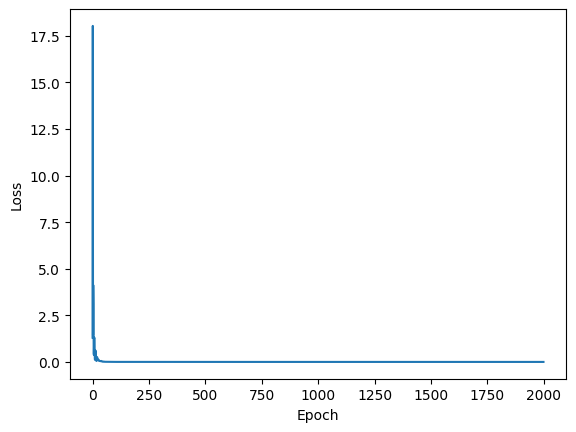

In [650]:
plt.plot(loss_data, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

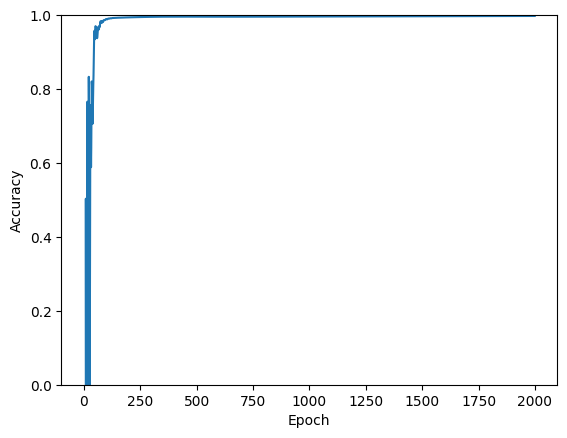

In [651]:
plt.plot(accuracy_data, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.show()